# 02d Estimation of the SED shape by varying airmass

- author Sylvie Dagoret-Campagne
- creation date : 2023/03/01
- last verification : 2024/01/04

### Use libraries

- getObsAtmo : for atmosphere emulation : https://github.com/LSSTDESC/getObsAtmo/tree/main
- rubinsimphot : a simplified version of rubin_sim : https://github.com/sylvielsstfr/rubinsimphot

**Goal** : shows the sensitivity to the SED slope in some band with color dependence

- simulate many atmospheric conditions
- simulate many SEDs and their redshifts

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import copy

In [2]:
from scipy import interpolate

In [3]:
from astropy import constants as const
from astropy import units as u

In [4]:
machine_name = os.uname().nodename

if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environement for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),"repos/repos_w_2023_44/rubinsimphot/src")
    sys.path.append(newpythonpath)
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environnement named conda_py310")
else:
    print("Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environnement named conda_py310


## Imports dedicated to this work

- import the atmospheric transparency emulator (instead of using libradtran code).
- import rubin sim
- import libPhotometricCorrections : encapsulate uninteresting calculation details

### libradtran Emulator

In [5]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.1


In [6]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo()

LSST site name validated as LSST observatory


In [7]:
WL = emul.GetWL()

In [8]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit

In [9]:
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


https://github.com/lsst/rubin_sim_notebooks/blob/main/photometry/calculating_snr.ipynb

In [10]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir
from rubinsimphot.phot_utils import PhotometricParameters 
from rubinsimphot.site_models import SeeingModel
from rubinsimphot.phot_utils import signaltonoise
from rubinsimphot.phot_utils import calc_neff

In [11]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [12]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [13]:
seeing_model = SeeingModel()
def seeing_at_X(obs_filter, obs_X, atmospheric_seeing_500nm=None, seeing_zenith=None):
    "Return FWHMeff in `obs_filter` at `obs_X`, providing either the seeing @ zenith (in filter) or the FWHM_500"
    if atmospheric_seeing_500nm is not None:
        idx = filterlist.index(obs_filter)
        fwhm_eff = seeing_model(atmospheric_seeing_500nm, obs_X)['fwhmEff'][idx]
    elif seeing_zenith is not None:
        # assume seeing_zenith is in the filter of choice and just approximate for airmass 
        airmass_correction = np.power(obs_X, 0.6)
        fwhm_eff = 1.16 * seeing_zenith * airmass_correction
    else:
        raise ValueErorr('Must specify atmospheric_seeing_500nm or seeing_zenith')
    return fwhm_eff

In [14]:
def calc_snr(sed, obs_filter, obs_skymag, obs_fwhm_eff, obs_X, 
             ref_filter, ref_mag, 
             exptime=15, nexp=2, verbose=False):
    obs_sky = scale_sky(obs_skymag, obs_filter)
    lsst_x = throughput_at_X(obs_X)
    scaled_sed = scale_sed(ref_mag, ref_filter, sed)
    photParams = set_photometric_parameters(exptime, nexp)
    snr = SignalToNoise.calc_snr_sed(scaled_sed, lsst_x[obs_filter], 
                                    obs_sky, lsst_hardware[obs_filter], 
                                    photParams, fwhm_eff=obs_fwhm_eff, 
                                    verbose=verbose)
    return snr

## Configuration

In [15]:
path_rubin_sim_throughput=os.path.join(get_data_dir(),"throughputs/baseline")

In [16]:
darksky = Sed()
darksky.read_sed_flambda(os.path.join(path_rubin_sim_throughput, 'darksky.dat'))

In [17]:
index_sel = np.where(np.logical_and(darksky.wavelen>=WLMIN,darksky.wavelen<WLMAX))[0]
wav = darksky.wavelen[index_sel]
fll = darksky.flambda[index_sel]
darksel = Sed(wavelen=wav, flambda=fll)

Text(0, 0.5, '$F_\\lambda (\\lambda)$')

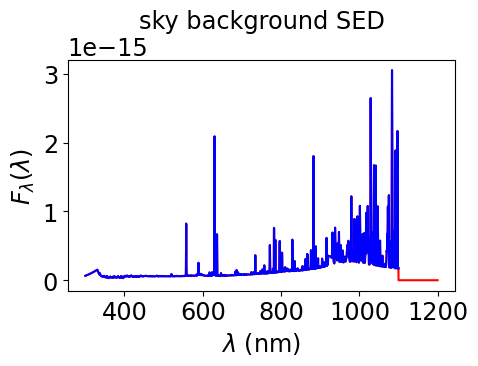

In [18]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
axs.plot(darksky.wavelen,darksky.flambda,'r-')
axs.plot(darksel.wavelen,darksel.flambda,'b-')
axs.set_title("sky background SED")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_ylabel("$F_\lambda (\lambda)$")

## Chose a Standard atmosphere

In [19]:
am0 =1.20    # airmass
pwv0 = 5.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.0# Aerosol Angstrom exponent

### Initialisation of Atmospheric corrections

In [20]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### Check standard atmosphere

Text(0.5, 1.0, 'Standard atmosphere transmission')

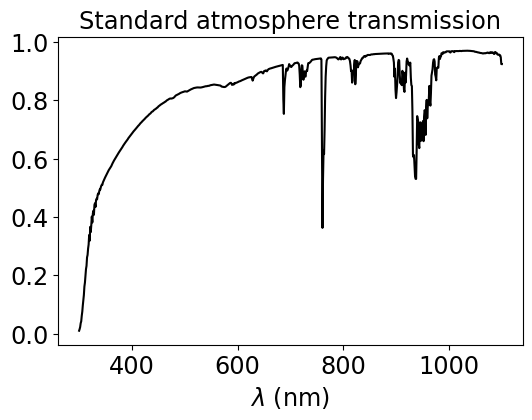

In [21]:
fig, axs = plt.subplots(1,1,figsize=(6,4))
axs.plot(pc.WL,pc.atm_std,'k-')
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Standard atmosphere transmission")

## Pickup an SED

In [22]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [23]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'photoZ_outliers' ,'quasar'] 
sedtypes_not_used = ['sn','stars' ,'white_dwarf']
sedtypes = sedtypes 

NSEDTYPES = len(sedtypes)

# dictionnary indexed by sed-name
seds = {}      # dictionnary that will contain the `rubin_sim` seds-Flambdas
sedsfnu = {}   # dictionnary that will contain the `rubin_sim` seds-Fnu
sedtypeslists = {}  # dictionnary that contain the SED type
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].read_sed_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        


In [24]:
df_SED=df_SED.set_index('name')
df_SED

,type
name,
Sa_template_norm,galaxies
Sdm_template_norm0,galaxies
Ell2_template_norm,galaxies
xspec_173,photoZ_outliers
xspec_172,photoZ_outliers
xspec_90,photoZ_outliers
xspec_91,photoZ_outliers
xspec_176,photoZ_outliers
xspec_175,photoZ_outliers


In [25]:
dict_selected_galaxies = { 'Sa_template_norm' : {0.0,1.4,1.6}, 'Ell2_template_norm' : {0.0,1.4,1.6}, 'xspec_173':{0.0,1.4,1.6} , 'quasar' : [0.0,1.0,2.4] }

In [26]:
renorm_mag_inZ = 20

all_selected_sed = []
all_tag_sed = []
for key, all_z in dict_selected_galaxies.items():
  
    for z in all_z:
        the_sed = copy.deepcopy(seds[key])
        the_sed.redshift_sed(z)
        flux_norm = the_sed.calc_flux_norm(renorm_mag_inZ, pc.bandpass_total_std['z'])
        the_sed.multiply_flux_norm(flux_norm)
        
        the_sed_name = key+f" z={z:.1f}"
        all_selected_sed.append(the_sed)
        all_tag_sed.append(the_sed_name)
          

In [27]:
sed_flat = Sed()
sed_flat.set_flat_sed()
flux_norm = sed_flat.calc_flux_norm(20, pc.bandpass_total_std['z'])
sed_flat.multiply_flux_norm(flux_norm)

all_selected_sed.append(sed_flat) 
all_tag_sed.append('flat')

In [28]:
NSEDSEL = len(all_selected_sed)
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSEDSEL)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSEDSEL), alpha=1)

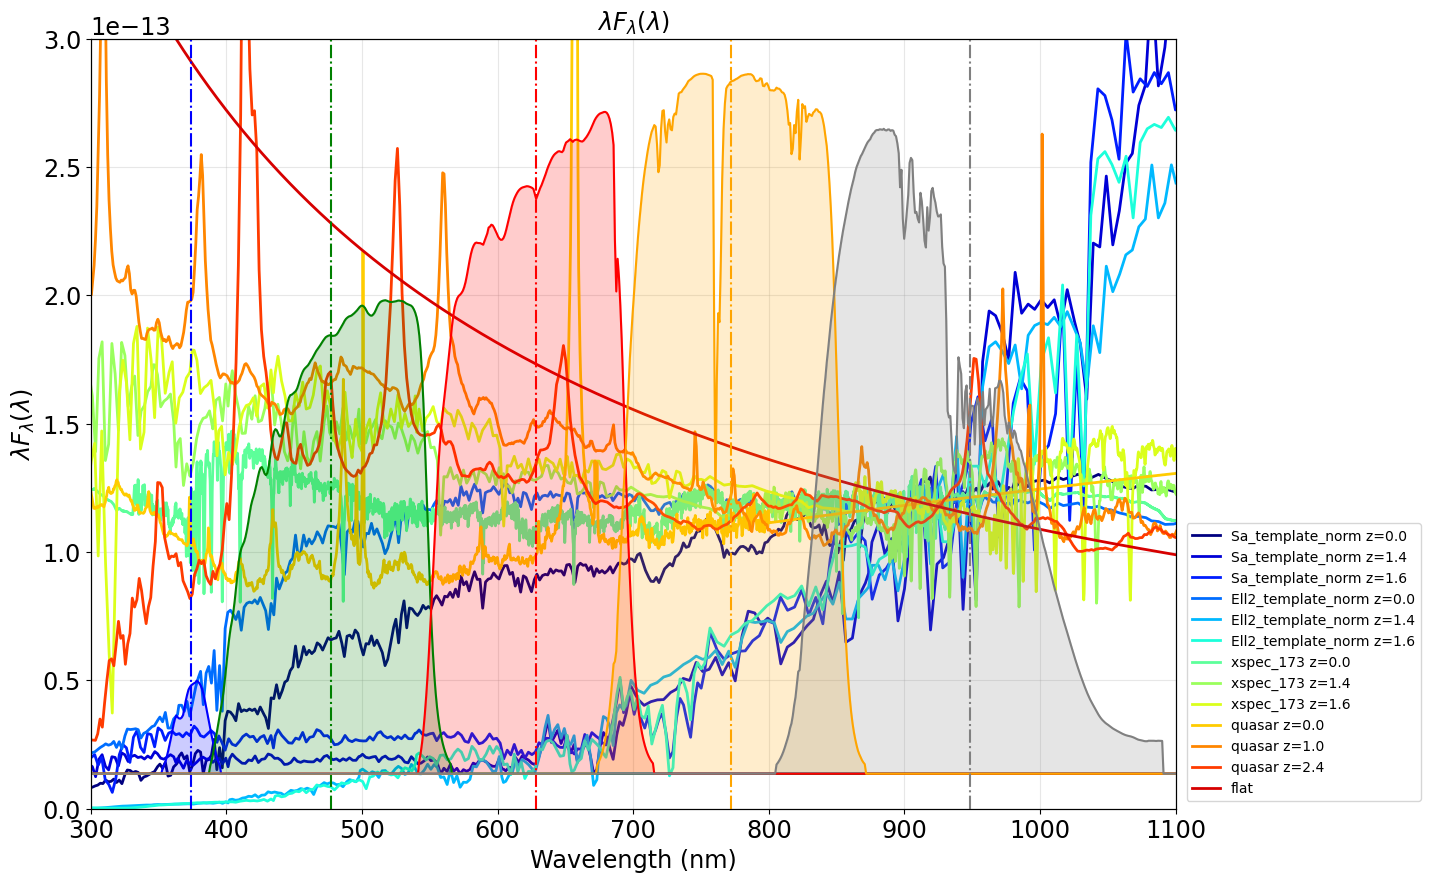

In [29]:
fig, ax = plt.subplots(1,1,figsize=(14,10))
all_flmax = np.zeros(NSEDSEL)


for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    ax.plot(the_sed.wavelen, the_sed.flambda * the_sed.wavelen,"-",color=all_colors[idx],label=all_tag_sed[idx],lw=2)
    #idx_inrange = np.where(np.logical_and(the_sed.flambda>=WLMIN, the_sed.flambda<WLMAX))[0]
    #flinrange = (the_sed.flambda * the_sed.wavelen)[idx_inrange]
    #all_flmax[idx] = np.max(flinrange)
    
ax.set_ylim(0,3e-13)    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\lambda F_\lambda(\lambda)$")
ax.set_title("$\lambda F_\lambda(\lambda)$")
ax2 = ax.twinx()

for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])

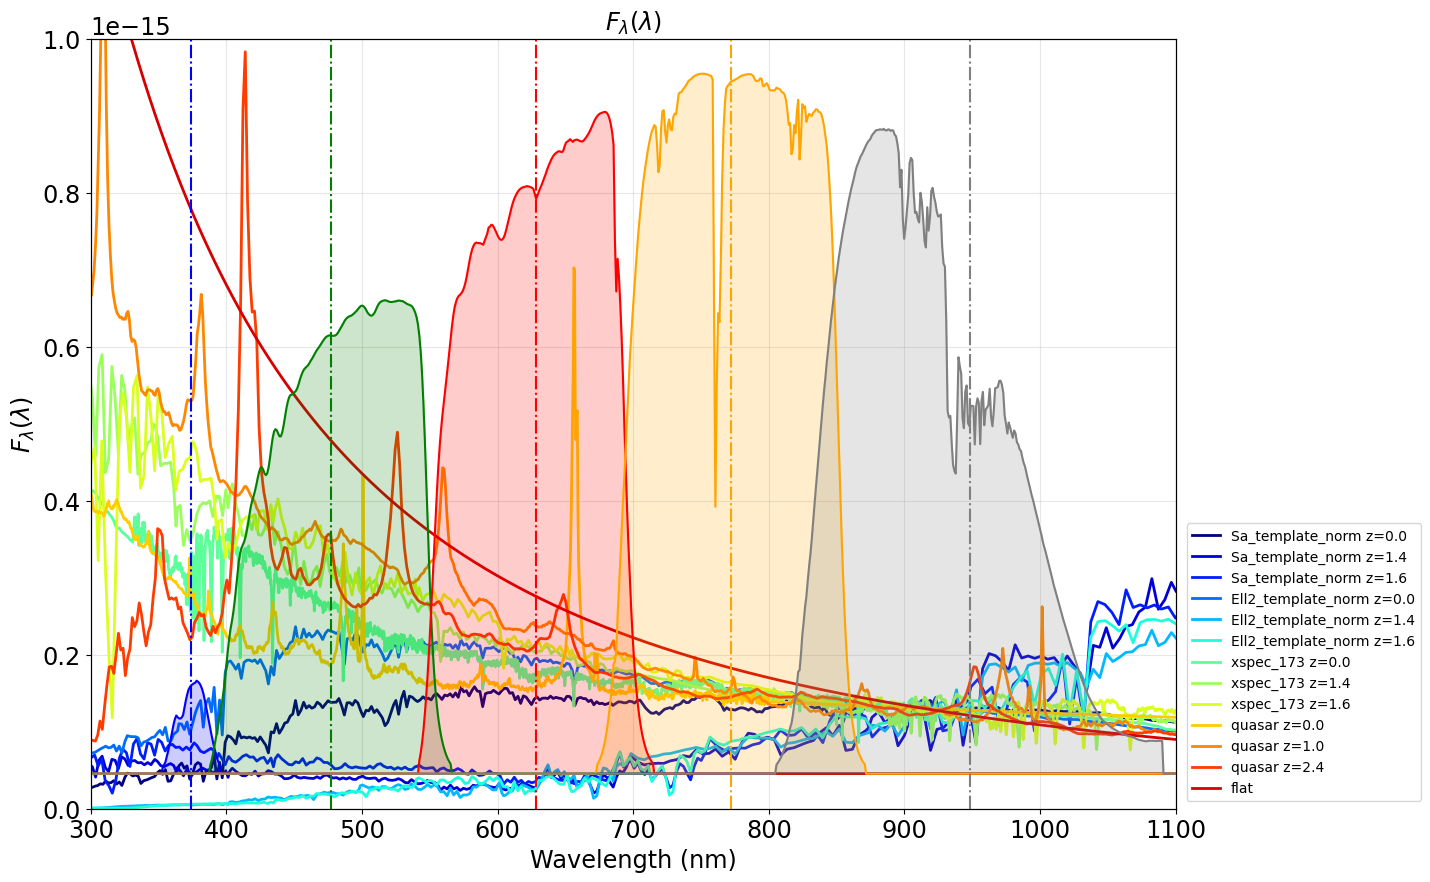

In [30]:
fig, ax = plt.subplots(1,1,figsize=(14,10))


for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    ax.plot(the_sed.wavelen, the_sed.flambda ,"-",color=all_colors[idx],label=all_tag_sed[idx],lw=2)
    #idx_inrange = np.where(np.logical_and(the_sed.flambda>=WLMIN, the_sed.flambda<WLMAX))[0]
    #flinrange = (the_sed.flambda * the_sed.wavelen)[idx_inrange]
    #all_flmax[idx] = np.max(flinrange)

ax.set_ylim(0,1e-15)
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\lambda(\lambda)$")
ax.set_title("$F_\lambda (\lambda)$")
ax2 = ax.twinx()

for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

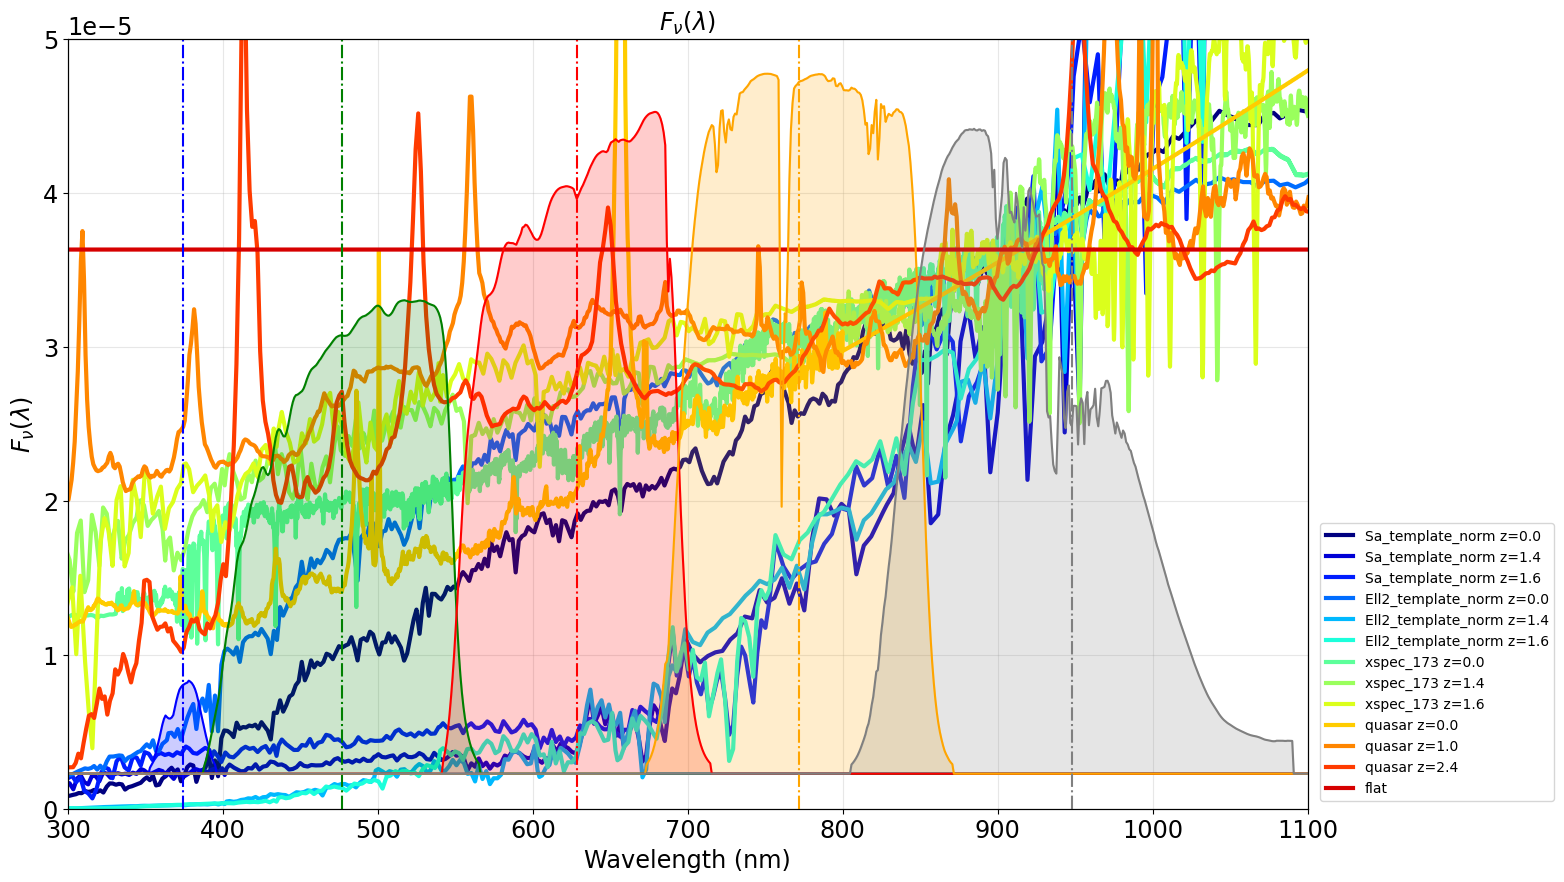

In [31]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(16,10))
for idx in range(NSEDSEL):
    the_sed = all_selected_sed[idx]
    wavel,fnu = the_sed.get_sed_fnu()
    ax.plot(wavel, fnu,"-",color=all_colors[idx],label=all_tag_sed[idx],lw=3)


ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

indexes_sel = np.where(np.logical_and(wavel>WLMIN,wavel<WLMAX))[0]
flmax = np.max(fnu[indexes_sel])
ax.set_ylim(0,5e-5)
                       

ax2 = ax.twinx()
for index,f in enumerate(filter_tagnames):
    
    ax2.plot(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index]) 
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[index],alpha=0.2) 
    ax2.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    ax2.set_yticks([])
    

# Usefull photometric values from rubin_sim

In [32]:
photoparams = set_photometric_parameters(15, 2 , readnoise=None)

In [33]:
# constant in zero point
F0AB = 3631*(1*u.Jy).cgs.value
Z0PTconst = 2.5*np.log10((F0AB*photoparams.effarea*photoparams.nexp*photoparams.exptime)/(photoparams.gain*const.h.cgs.value))

z0pt_std= {}
for index,f in enumerate(filter_tagnames):
    z0pt_std[f] = Z0PTconst + 2.5*np.log10(pc.all_II0_std[f])
pd.DataFrame(z0pt_std, index=["z0pt_std"]).T    

,z0pt_std
u,27.951779
g,31.194512
r,31.241516
i,31.287082
z,30.927315


# Create a series of observations

In [34]:
AIRMASSMIN = 1
AIRMASSMAX = 2.5
DAIRMASS= AIRMASSMAX-AIRMASSMIN 
NOBS = 100

In [35]:
all_am = DAIRMASS*np.random.rand(NOBS) + AIRMASSMIN

In [36]:
pc.CalculateMultiObs(all_am,pwv0,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


## Calculate ADCs values for each SED

In [37]:
all_df_std = []
all_df_nonstd_Z = []

for idx_sed in range(NSEDSEL):
    the_sed = all_selected_sed[idx_sed]
    
    #standard values
    adcs_std = np.zeros(NFILT)
    z0pt_std = np.zeros(NFILT)
    for idx_filt,f in enumerate(filter_tagnames) :
        adcs_std[idx_filt] = the_sed.calc_adu(pc.bandpass_total_std[f],photoparams)
        z0pt_std[idx_filt] = Z0PTconst + 2.5*np.log10(pc.all_II0_std[f])
        
    df_std = pd.DataFrame()
    df_std["adcs_std"] = adcs_std
    df_std["z0pt_std"] = z0pt_std
    all_df_std.append(df_std)
    
    
    #non standard values only in selected filter : Y
    all_adc = np.zeros(NOBS)
    all_ratioII0 = np.zeros(NOBS)
    all_subII1 = np.zeros(NOBS)
    selected_filter = "z"
    for idx_am,am in enumerate(all_am):
        lsst_band = pc.coll_bandpass_total_nonstd[idx_am][selected_filter]
        adcs_nonstd = the_sed.calc_adu(lsst_band,photoparams)
        all_adc[idx_am] = adcs_nonstd
        all_ratioII0[idx_am] = pc.allcollperfilter[selected_filter]["II0ratio_nonstd"][idx_am]
        all_subII1[idx_am] = pc.allcollperfilter[selected_filter]["II1sub_nonstd"][idx_am]
        
    df_nonstd = pd.DataFrame()
    df_nonstd["adcs_nonstd"] = all_adc
    df_nonstd["ratioII0_nonstd"] = all_ratioII0
    df_nonstd["subII1_nonstd"] = all_subII1
    df_nonstd["am"] = all_am
    
    all_df_nonstd_Z.append(df_nonstd)
    
    

In [38]:
all_df_std[1]

,adcs_std,z0pt_std
0,97.081593,27.951779
1,2541.364130,31.194512
2,3874.178360,31.241516
3,13891.251415,31.287082
4,23492.330665,30.927315


In [39]:
all_df_std[1]["z0pt_std"]

0    27.951779
1    31.194512
2    31.241516
3    31.287082
4    30.927315
Name: z0pt_std, dtype: float64

In [40]:
all_df_nonstd_Z[0]

,adcs_nonstd,ratioII0_nonstd,subII1_nonstd,am
0,22983.226161,0.978848,0.194376,1.494878
1,21637.283156,0.922705,0.646571,2.397269
2,21914.252616,0.934284,0.560645,2.196764
3,22676.649372,0.966088,0.305072,1.684680
4,21649.772724,0.923227,0.642721,2.388116
...,...,...,...,...
95,23773.443435,1.011658,-0.113490,1.048281
96,21608.850307,0.921516,0.655108,2.418376
97,22408.539473,0.954915,0.398045,1.858288
98,22203.188056,0.946349,0.467081,1.995974


### Convergence toward the true magnitude in std filter

Text(0, 0.5, 'airmass')

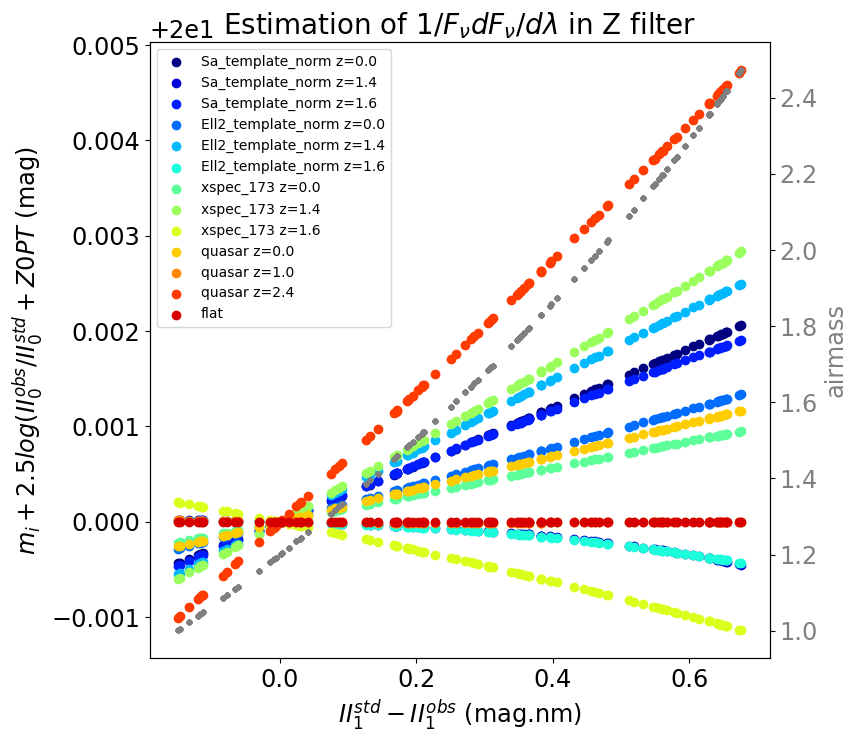

In [41]:
fig, axs = plt.subplots(1,1,figsize=(8,8))

for idx_sed in range(NSEDSEL):
    all_adc = all_df_nonstd_Z[idx_sed]["adcs_nonstd"].values
    all_ratioII0 = all_df_nonstd_Z[idx_sed]["ratioII0_nonstd"].values
    all_subII1 = all_df_nonstd_Z[idx_sed]["subII1_nonstd"].values
    z0pt_std_iny = all_df_std[idx_sed]["z0pt_std"].iloc[4]

    y = -2.5*np.log10(all_adc) + 2.5*np.log10(all_ratioII0) + z0pt_std_iny
    
    x = all_subII1
    axs.scatter(x,y,color=all_colors[idx_sed],label=all_tag_sed[idx_sed])
    
axs.legend()
axs.set_xlabel("$II_1^{std} - II_1^{obs}$ (mag.nm)")
axs.set_ylabel("$m_i + 2.5log(II_0^{obs}/II_0^{std} + Z0PT$ (mag)")
axs.set_title("Estimation of $1/F_{\\nu} dF_{\\nu}/d\\lambda$ in Z filter",fontsize=20)

axs2 = axs.twinx() 
for idx_sed in range(NSEDSEL):
    
    all_subII1 = all_df_nonstd_Z[idx_sed]["subII1_nonstd"].values
    am = all_df_nonstd_Z[idx_sed]["am"].values
    
    y = am
    x = all_subII1

    axs2.scatter(x,y,marker=".",color="grey")
axs2.tick_params(axis='y', labelcolor="grey")
axs2.set_ylabel("airmass",color="grey")

### Substract the target standard magnitude

- the magnitude for which the SED was renormalized in the Y filter

Text(0, 0.5, 'airmass')

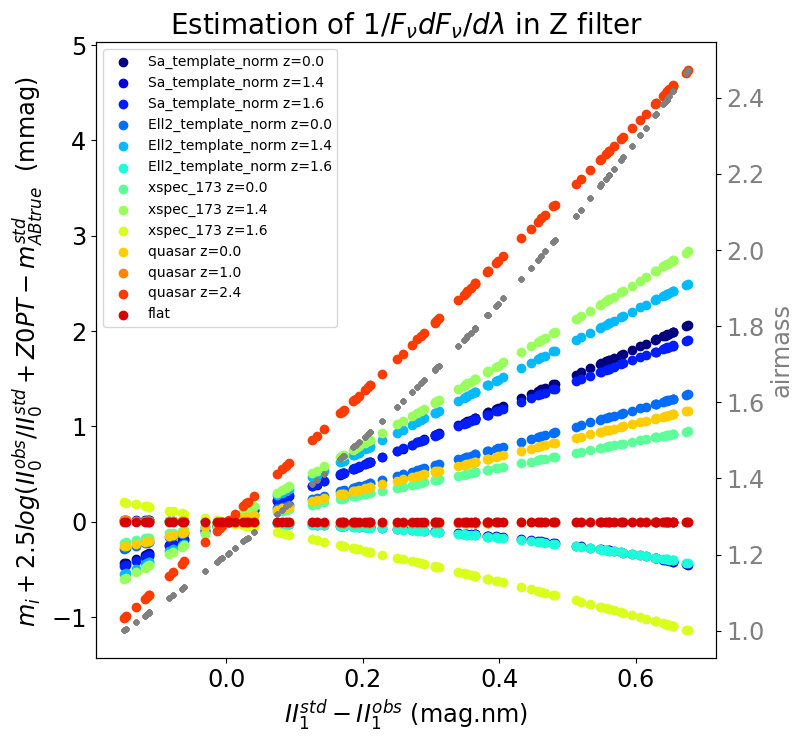

In [42]:
fig, axs = plt.subplots(1,1,figsize=(8,8))

for idx_sed in range(NSEDSEL):
    all_adc = all_df_nonstd_Z[idx_sed]["adcs_nonstd"].values
    all_ratioII0 = all_df_nonstd_Z[idx_sed]["ratioII0_nonstd"].values
    all_subII1 = all_df_nonstd_Z[idx_sed]["subII1_nonstd"].values
    z0pt_std_iny = all_df_std[idx_sed]["z0pt_std"].iloc[4]

    y = -2.5*np.log10(all_adc) + 2.5*np.log10(all_ratioII0) + z0pt_std_iny - renorm_mag_inZ
    
    y *= 1000
    x = all_subII1
    axs.scatter(x,y,color=all_colors[idx_sed],label=all_tag_sed[idx_sed])
    
axs.legend()
axs.set_xlabel("$II_1^{std} - II_1^{obs}$ (mag.nm)")
axs.set_ylabel("$m_i + 2.5log(II_0^{obs}/II_0^{std} + Z0PT -m_{AB true}^{std}$  (mmag) ")
axs.set_title("Estimation of $1/F_{\\nu} dF_{\\nu}/d\\lambda$ in Z filter",fontsize=20)

axs2 = axs.twinx() 
for idx_sed in range(NSEDSEL):
    
    all_subII1 = all_df_nonstd_Z[idx_sed]["subII1_nonstd"].values
    am = all_df_nonstd_Z[idx_sed]["am"].values
    
    y = am
    x = all_subII1

    axs2.scatter(x,y,marker=".",color="grey")
axs2.tick_params(axis='y', labelcolor="grey")
axs2.set_ylabel("airmass",color="grey")

# try for all bands

In [43]:
all_df_std = []
all_df_nonstd = []

for idx_sed in range(NSEDSEL):
    the_sed = all_selected_sed[idx_sed]
    
    #standard values
    magtrue_std = np.zeros(NFILT)
    adcs_std = np.zeros(NFILT)
    z0pt_std = np.zeros(NFILT)
    for idx_filt,f in enumerate(filter_tagnames) :
        adcs_std[idx_filt] = the_sed.calc_adu(pc.bandpass_total_std[f],photoparams)
        z0pt_std[idx_filt] = Z0PTconst + 2.5*np.log10(pc.all_II0_std[f])
        magtrue_std[idx_filt] = the_sed.calc_mag(pc.bandpass_total_std[f])
        
    df_std = {}
    df_std["adcs_std"] = adcs_std
    df_std["z0pt_std"] = z0pt_std
    df_std["mag_std"] =  magtrue_std
    all_df_std.append(df_std)
    
    
    #non standard values only in selected filter : Z
    all_adc = np.zeros((NFILT,NOBS))
    all_ratioII0 = np.zeros((NFILT,NOBS))
    all_subII1 = np.zeros((NFILT,NOBS))
    for idx_filt,f in enumerate(filter_tagnames):
        for idx_am,am in enumerate(all_am):
            lsst_band = pc.coll_bandpass_total_nonstd[idx_am][f]
            adcs_nonstd = the_sed.calc_adu(lsst_band,photoparams)
            all_adc[idx_filt,idx_am] = adcs_nonstd
            all_ratioII0[idx_filt,idx_am] = pc.allcollperfilter[f]["II0ratio_nonstd"][idx_am]
            all_subII1[idx_filt,idx_am] = pc.allcollperfilter[f]["II1sub_nonstd"][idx_am]
        
    df_nonstd = {}
    df_nonstd["adcs_nonstd"] = all_adc
    df_nonstd["ratioII0_nonstd"] = all_ratioII0
    df_nonstd["subII1_nonstd"] = all_subII1
    df_nonstd["am"] = all_am
    
    all_df_nonstd.append(df_nonstd)
    
    

In [44]:
all_df_std[0] 

{'adcs_std': array([   98.26303562,  8038.53173366, 16326.54650186, 23938.51612839,
        23492.33066523]),
 'z0pt_std': array([27.95177941, 31.19451238, 31.24151584, 31.28708164, 30.92731491]),
 'mag_std': array([22.97080432, 21.4315709 , 20.70928037, 20.33933893, 20.        ])}

In [45]:
all_df_std[1] 

{'adcs_std': array([   97.08159323,  2541.36413028,  3874.17836044, 13891.25141496,
        23492.33066523]),
 'z0pt_std': array([27.95177941, 31.19451238, 31.24151584, 31.28708164, 30.92731491]),
 'mag_std': array([22.98393752, 22.68184549, 22.27106717, 20.93022856, 20.        ])}

In [46]:
all_df_std[2] 

{'adcs_std': array([  153.36283221,  3659.90459536,  4848.48305749, 13871.03574265,
        23492.33066523]),
 'z0pt_std': array([27.95177941, 31.19451238, 31.24151584, 31.28708164, 30.92731491]),
 'mag_std': array([22.48747946, 22.28583832, 22.02750149, 20.93180976, 20.        ])}

In [47]:
#all_df_nonstd[0]

Text(0.5, 1, 'Estimation of $1/F_{\\nu} dF_{\\nu}/d\\lambda$ in all filter, varying airmass')

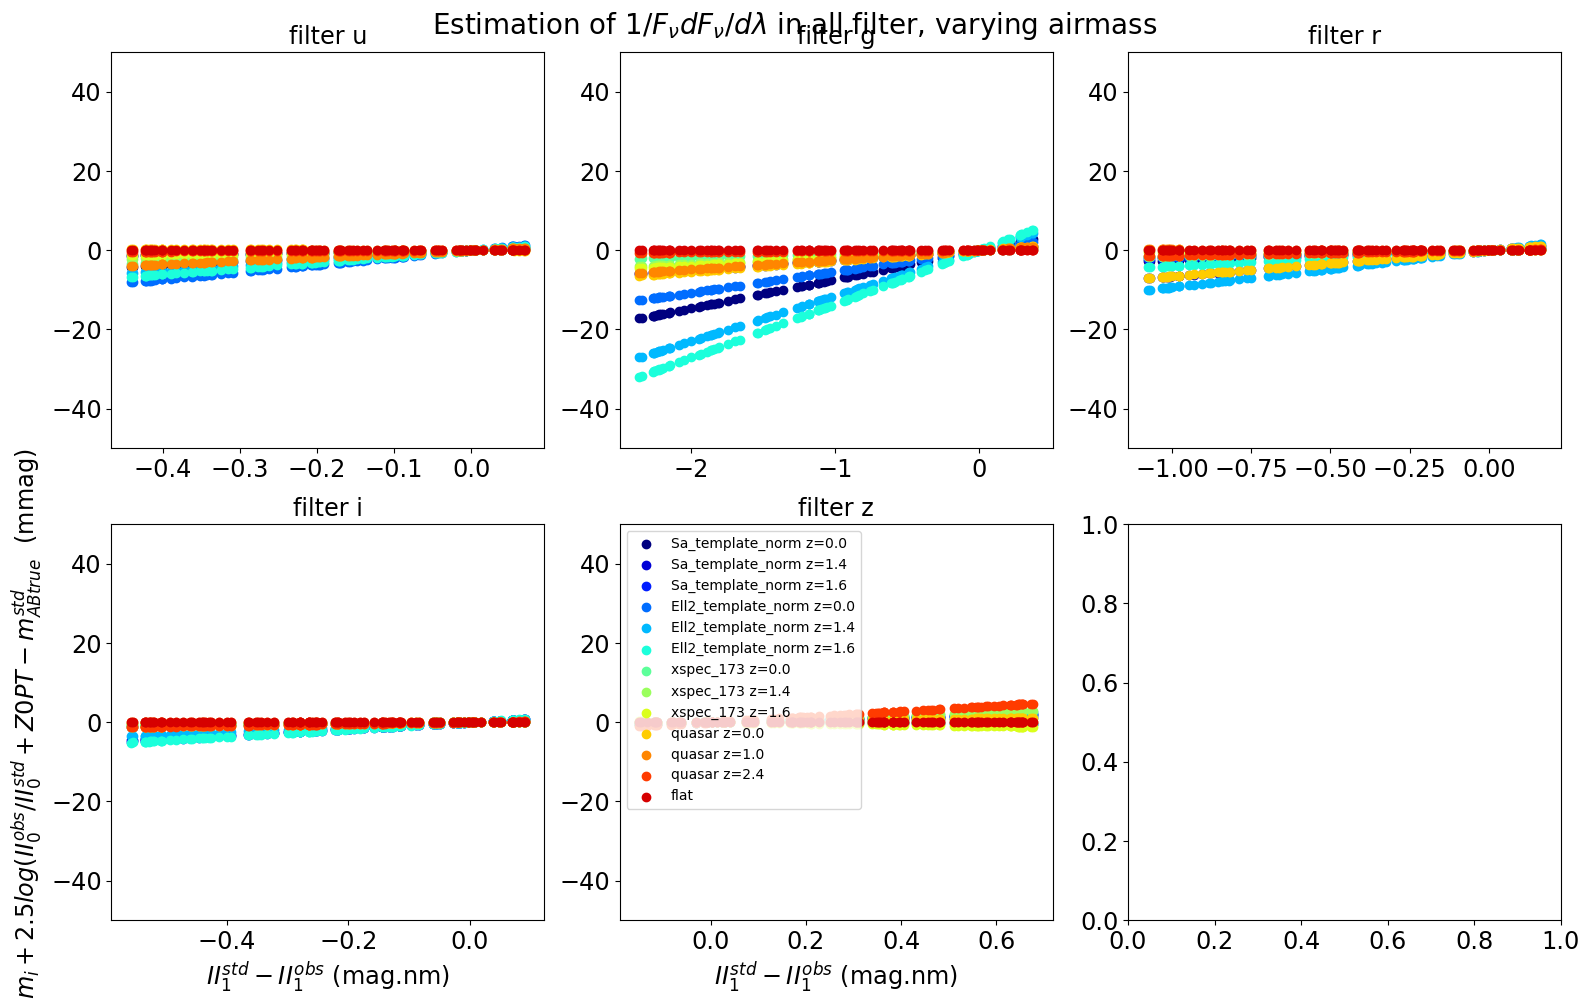

In [48]:
NCOLS =3
NROWS = 2

fig, axs = plt.subplots(NROWS,NCOLS,figsize=(16,10))

# main loop on filters
for idx_filt,f in enumerate(filter_tagnames):
    iy = idx_filt//NCOLS
    ix = idx_filt - NCOLS*iy
    
    # loop on SED
    for idx_sed in range(NSEDSEL):
        all_adc = all_df_nonstd[idx_sed]["adcs_nonstd"][idx_filt,:]
        all_ratioII0 = all_df_nonstd[idx_sed]["ratioII0_nonstd"][idx_filt,:]
        all_subII1 = all_df_nonstd[idx_sed]["subII1_nonstd"][idx_filt,:]
        z0pt_std = all_df_std[idx_sed]["z0pt_std"][idx_filt]
        magtrue_std = all_df_std[idx_sed]["mag_std"][idx_filt]
        

        y = -2.5*np.log10(all_adc) + 2.5*np.log10(all_ratioII0) + z0pt_std - magtrue_std
        y *=1000
        x = all_subII1
        axs[iy,ix].scatter(x,y,color=all_colors[idx_sed],label=all_tag_sed[idx_sed])
        axs[iy,ix].set_title(f"filter {f}")
        #if idx_filt==5:
        axs[iy,ix].set_ylim(-50,50)
        #else:
        #    axs[iy,ix].set_ylim(-5,5)
            
        if idx_filt==4:    
            axs[iy,ix].legend()
            
        if iy== NROWS-1:
            axs[iy,ix].set_xlabel("$II_1^{std} - II_1^{obs}$ (mag.nm)")
        if ix== 0 and iy== NROWS-1:
            axs[iy,ix].set_ylabel("$m_i + 2.5log(II_0^{obs}/II_0^{std} + Z0PT -m_{AB true}^{std}$  (mmag) ")
        #axs[iy,ix].set_title("Estimation of $1/F_{\\nu} dF_{\\nu}/d\\lambda$ in Y filter",fontsize=20)

plt.tight_layout()        
plt.suptitle("Estimation of $1/F_{\\nu} dF_{\\nu}/d\\lambda$ in all filter, varying airmass",fontsize=20,y=1)    
    
